In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')



In [2]:
train = pd.read_csv("train-v3.csv", encoding = "ISO-8859-1", engine='python')
test = pd.read_csv("test-v3.csv", encoding = "ISO-8859-1", engine='python')
valid =  pd.read_csv("valid-v3.csv", encoding = "ISO-8859-1", engine='python')

In [3]:
print(train[train.isnull().T.any()])#檢查是否有空值，並印出有空值的行

print(train.corr(method='kendall'))

Empty DataFrame
Columns: [id, price, sale_yr, sale_month, sale_day, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

[0 rows x 23 columns]
                     id     price   sale_yr  sale_month  sale_day  bedrooms  \
id             1.000000  0.003376  0.009090   -0.010033  0.001005  0.002077   
price          0.003376  1.000000  0.006183   -0.018766 -0.010538  0.262559   
sale_yr        0.009090  0.006183  1.000000   -0.684712  0.000948  0.000867   
sale_month    -0.010033 -0.018766 -0.684712    1.000000 -0.045769 -0.007086   
sale_day       0.001005 -0.010538  0.000948   -0.045769  1.000000 -0.003637   
bedrooms       0.002077  0.262559  0.000867   -0.007086 -0.003637  1.000000   
bathrooms      0.009817  0.373276 -0.011321   -0.004969  0.001236  0.439622   
sqft_living   -0.001239  0.463471 -0.016969    0.001074 -0.002042  0.521536   
sq

In [4]:
train_y = train.iloc[0:,1:2]
valid_y = valid.iloc[0:,1:2]
train_x = train.drop(columns= ["price","id"])
valid_x = valid.drop(columns= ["price","id"])
test_id = test["id"].values.tolist()
#print(test_id)
test_x = test.drop(columns= ["id"])
print(train_x.shape)
# test_x.shape
# valid_x.shape
# train_x
# if train_x["renovation"]==0:
#     print(train_x["yr_built"])
def renovate(df):
    #df = train_x
    count = 0 
    for a in df["yr_renovated"]:
        #print(count)
        if a == 0:
            df["yr_renovated"][count] = df["yr_built"][count]
        count=count+1

    #     if i["yr_renovated"]==0:
    #         i["yr_renovated"] = i["yr_built"]
    df["yr_renovated"][99]
    return df
train_x =  renovate(train_x)
valid_x =  renovate(valid_x)
test_x =  renovate(test_x)

# from sklearn.preprocessing import OneHotEncoder
# onehotencoder = OneHotEncoder(categorical_features = [0])
# data_str_ohe=onehotencoder.fit_transform(data_le).toarray()
# pd.DataFrame(data_str_ohe)

def zipcode(df):
    df_dum=pd.get_dummies(df['zipcode'])
    #print(df_dum.shape)
    df.drop(columns= ["zipcode"])
    df_new=pd.concat([df,df_dum],axis=1)
    return df_new

train_x =  zipcode(train_x)
valid_x =  zipcode(valid_x)
test_x =  zipcode(test_x)


(12967, 21)


In [5]:

def drop(df_date):
    df_date = df_date.drop(columns= ["sale_yr", "sale_month","sale_day","condition","sqft_lot15"])  
    return df_date
train_x = drop(train_x)
test_x = drop(test_x)
valid_x = drop(valid_x)
from sklearn import preprocessing
#建立MinMaxScaler物件
minmax = preprocessing.MinMaxScaler()#新資料=（原資料-最小值）/（最大值-最小值）
# 資料標準化
train_x = minmax.fit_transform(train_x)
test_x = minmax.fit_transform(test_x)
valid_x = minmax.fit_transform(valid_x)


#data['sepal length (cm)'] = (data['sepal length (cm)'] - data['sepal length (cm)'].min())/\(data['sepal length (cm)'].max() - data['sepal length (cm)'].mi
#data['sepal width (cm)'] = (data['sepal width (cm)'] - data['sepal width (cm)'].mean())/\(data['sepal width (cm)'].std())
#data.head()

In [20]:
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from matplotlib import pyplot as plt
earlystop_callback = EarlyStopping(monitor='val_mae',min_delta=0.0001,patience=1)

def build_deep_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(train_x.shape[1],), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation="relu"))
    #odel.add(Dropout(0.1))
    model.add(Dense(8, activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(8, activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(8, activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(8, activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(1))
    # 編譯模型
    model.compile(loss="mse", optimizer="adam",
    metrics=["mae"])
    return model
k = 3
nb_val_samples = len(train_x) // k
nb_epochs = 150
mse_scores = []
mae_scores = []
for i in range(k):
    print("Processing Fold #" + str(i))
    # 取出驗證資料集
    X_val = train_x[i*nb_val_samples: (i+1)*nb_val_samples]
    Y_val = train_y[i*nb_val_samples: (i+1)*nb_val_samples]
    # 結合出訓練資料集
    X_train_p = np.concatenate(
    [train_x[:i*nb_val_samples],
    train_x[(i+1)*nb_val_samples:]], axis=0)
    Y_train_p = np.concatenate(
    [train_y[:i*nb_val_samples],
    train_y[(i+1)*nb_val_samples:]], axis=0)
    model = build_deep_model()
    # 訓練模型
    history = model.fit(X_train_p, Y_train_p, epochs=nb_epochs,callbacks=[earlystop_callback],validation_data = (X_val, Y_val),
    validation_freq=1,batch_size=16, verbose=1)
    # 評估模型
    #plot(history)
    mse, mae = model.evaluate(X_val, Y_val)
    mse_scores.append(mse)
    mae_scores.append(mae)
print("MSE_kfold: ", np.mean(mse_scores))
print("MAE_kfold: ", np.mean(mae_scores))

mse, mae = model.evaluate(train_x, train_y)
print("MSE_train: ", mse)
print("MAE_train: ", mae)
# 使用測試資料評估模型
mse, mae = model.evaluate(valid_x, valid_y)
print("MSE_valid: ", mse)
print("MAE_valid: ", mae)

Processing Fold #0
Epoch 1/150
541/541 [==============================] - 1s 2ms/step - loss: 182365487104.0000 - mae: 283506.0938 - val_loss: 66449444864.0000 - val_mae: 134290.9844
Epoch 2/150
541/541 [==============================] - 2s 3ms/step - loss: 56401481728.0000 - mae: 142790.0781 - val_loss: 37825888256.0000 - val_mae: 100214.2812
Epoch 3/150
541/541 [==============================] - 1s 2ms/step - loss: 42656985088.0000 - mae: 128478.5703 - val_loss: 30285690880.0000 - val_mae: 95059.1016
Epoch 4/150
136/136 [==============================] - 0s 927us/step - loss: 31257724928.0000 - mae: 97430.1484
Processing Fold #1
Epoch 1/150
541/541 [==============================] - 1s 2ms/step - loss: 180780220416.0000 - mae: 281648.9688 - val_loss: 64197423104.0000 - val_mae: 142958.4375
Epoch 2/150
541/541 [==============================] - 1s 2ms/step - loss: 59569016832.0000 - mae: 144030.3125 - val_loss: 31903645696.0000 - val_mae: 100347.9141
Epoch 3/150
541/541 [=============

In [ ]:
# from keras import Sequential
# from keras.callbacks import EarlyStopping
# from keras.layers import Dense
# from keras.layers import Dropout
# from matplotlib import pyplot as plt
# earlystop_callback = EarlyStopping(monitor='val_mae',min_delta=0.0001,patience=1)

# #def build_deep_model():
# model = Sequential()
# model.add(Dense(128, input_shape=(train_x.shape[1],), activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation="relu"))
# model.add(Dropout(0.1))
# model.add(Dense(16, activation="relu"))
# model.add(Dropout(0.1))
# model.add(Dense(16, activation="relu"))
# model.add(Dropout(0.1))
# model.add(Dense(16, activation="relu"))
# model.add(Dropout(0.1))
# model.add(Dense(8, activation="relu"))
# model.add(Dropout(0.1))
# model.add(Dense(8, activation="relu"))
# #model.add(Dropout(0.1))
# model.add(Dense(8, activation="relu"))
# #model.add(Dropout(0.1))
# model.add(Dense(8, activation="relu"))
# #model.add(Dropout(0.1))
# model.add(Dense(1))
# # 編譯模型
# model.compile(loss="mse", optimizer="adam",
# metrics=["mae"])

# history = model.fit(train_x, train_y, epochs=150,callbacks=[earlystop_callback],validation_data = (valid_x, valid_y),
# validation_freq=1,batch_size=16, verbose=1)
# mse, mae = model.evaluate(train_x, train_y)
# print("MSE_train: ", mse)
# print("MAE_train: ", mae)
# # 使用測試資料評估模型
# mse, mae = model.evaluate(valid_x, valid_y)
# print("MSE_valid: ", mse)
# print("MAE_valid: ", mae)

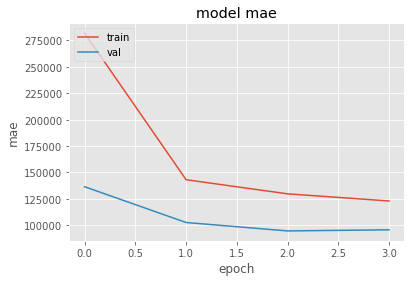

In [8]:

def plot(history):
    #print(history.history.keys())
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot(history)

In [9]:


def MAE(real, predict):
    print('MAE',np.mean(abs(real[:len(predict)]  - predict)))
y_pred_v = model.predict(valid_x)
y_pred = model.predict(test_x)
y_pred_train = model.predict(train_x)

MAE(valid_y,y_pred_v)
MAE(train_y,y_pred_train)


MAE price    117539.182809
dtype: float64
MAE price    92054.09375
dtype: float32


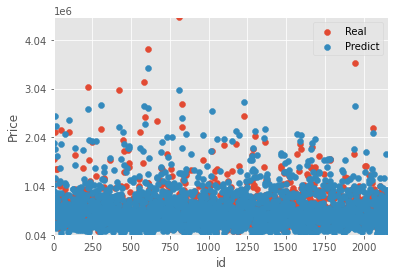

In [19]:

for i in range(len(valid)):
    valid['id'][i] = i
valid_ans = []
for i in y_pred_v:
    valid_ans.append(int(round(i[0])))
#print(train_ans)
#print(train['price'])
miny = min(np.concatenate([valid_ans,valid['price']]))
maxy = max(np.concatenate([valid_ans,valid['price']]))
#print(miny ,maxy)
plt.axis([min(valid['id']), max(valid['id']), miny, maxy])
#plt.xlim(min(train['id']), max(train['id']))
#plt.ylim(miny, maxy)
tick_arr = np.arange(miny, maxy,1000000) #產生刻度陣列(npArray 類似list)
plt.yticks(tick_arr)
plt.scatter(valid['id'], valid['price'], label='Real')
plt.scatter(valid['id'], valid_ans, label='Predict')
plt.xlabel('id')
plt.ylabel('Price')
plt.legend()




39197 7062500


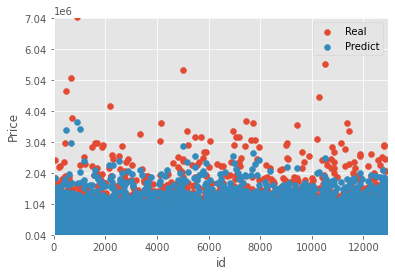

In [21]:
for i in range(len(train)):
    train['id'][i] = i
train_ans = []
for i in y_pred_train:
    train_ans.append(int(round(i[0])))
#print(train_ans)
#print(train['price'])
miny = min(np.concatenate([train_ans,train['price']]))
maxy = max(np.concatenate([train_ans,train['price']]))
print(miny ,maxy)
plt.axis([min(train['id']), max(train['id']), miny, maxy])
#plt.xlim(min(train['id']), max(train['id']))
#plt.ylim(miny, maxy)
tick_arr = np.arange(miny, maxy,1000000) #產生刻度陣列(npArray 類似list)
plt.yticks(tick_arr)
plt.scatter(train['id'], train['price'], label='Real')
plt.scatter(train['id'], train_ans, label='Predict')
plt.xlabel('id')
plt.ylabel('Price')
plt.legend()

In [22]:
#print(y_pred)
submit_ans = []
for i in y_pred:
    submit_ans.append(int(round(i[0])))
submit_ans
#MAE(valid_y,submit_ans)
import csv

# co_id_np = np.array(co_id)
# year_np = np.array(year)

# data = np.array([co_id_np, year_np])

# np.savetxt("sample.csv", data.T, fmt='%s', delimiter='\t')
    
    
#with open('submit.csv', 'w', newline='',encoding='UTF-8-sig') as test_file:
with open('311581024.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'price'])
    for x,y in zip (test_id,submit_ans):
        writer.writerow([x,y])